In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA

# --- Custom imports ---
from helpers import load_dataset_paths, load_vep_csv, compute_class_average_signal, summarize_results_and_save
from featex import FeatureExtractor
import os
from dimred import DimensionalityReducer

## Loading Preprocessed Files and Metadata

In [2]:

# ============================================================
# 0. LOAD DATA
# ============================================================
all_paths = load_dataset_paths()

prima_files_BC_only = all_paths["PRIMA"]["BC_Only"]
prima_files_RGC_only = all_paths["PRIMA"]["RGC_Only"]
prima_files_BC_and_RGC = all_paths["PRIMA"]["BC_and_RGC"]

print(f"PRIMA BC_Only files: {len(prima_files_BC_only)}")
print(f"PRIMA RGC_Only files: {len(prima_files_RGC_only)}")
print(f"PRIMA BC_and_RGC files: {len(prima_files_BC_and_RGC)}")

PRIMA BC_Only files: 138
PRIMA RGC_Only files: 67
PRIMA BC_and_RGC files: 32


In [3]:
from scipy.stats import pearsonr

# --- Load the per-category summary tables ---
snr_summary_BC = pd.read_csv("Preprocessed_VEP_Data/PRIMA/BC_Only/SNR_summary_BC_Only.csv")
snr_summary_RGC = pd.read_csv("Preprocessed_VEP_Data/PRIMA/RGC_Only/SNR_summary_RGC_Only.csv")
snr_summary_BC_and_RGC = pd.read_csv("Preprocessed_VEP_Data/PRIMA/BC_and_RGC/SNR_summary_BC_and_RGC.csv")

# --- Compute SNR ratio ---
for df in [snr_summary_BC, snr_summary_RGC, snr_summary_BC_and_RGC]:
    df["SNR_Ratio"] = df["SNR_Signal"] / df["SNR_Noise"]
    df["FileName"] = df["FileName"].str.strip()

# --- IQR-based outlier removal ---
def filter_by_iqr(df, label):
    q1, q3 = df["SNR_Ratio"].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    filtered = df[(df["SNR_Ratio"] >= lower) & (df["SNR_Ratio"] <= upper)].copy()

    n_removed = len(df) - len(filtered)
    mean_ratio, std_ratio = filtered["SNR_Ratio"].mean(), filtered["SNR_Ratio"].std()
    print(f"[{label}] kept {len(filtered):3d}/{len(df):3d} files  "
          f"({len(filtered)/len(df)*100:5.1f}% kept, {n_removed} removed)  "
          f"→ mean SNR ratio = {mean_ratio:6.2f} ± {std_ratio:6.2f}")
    return filtered

filtered_BC = filter_by_iqr(snr_summary_BC, "BC_Only")
filtered_RGC = filter_by_iqr(snr_summary_RGC, "RGC_Only")
filtered_BC_and_RGC = filter_by_iqr(snr_summary_BC_and_RGC, "BC_and_RGC")

# --- Match filenames back to actual file paths ---
def match_filtered_files(file_list, filtered_df, label):
    def normalize_name(name):
        base = os.path.basename(str(name)).strip().lower()
        if not base.endswith(".csv"):
            base += ".csv"
        return base

    filtered_names = [normalize_name(n) for n in filtered_df["FileName"]]
    file_map = {normalize_name(f): f for f in file_list}
    matched = [file_map[n] for n in filtered_names if n in file_map]
    skipped = [n for n in filtered_names if n not in file_map]
    print(f"[{label}] matched {len(matched)}/{len(filtered_names)} files ({len(skipped)} skipped)")
    if skipped:
        print("⚠️ Skipped (not matched):", ", ".join(skipped[:8]), "..." if len(skipped) > 8 else "")
    return matched

prima_files_BC_only = match_filtered_files(prima_files_BC_only, filtered_BC, "BC_Only")
prima_files_RGC_only = match_filtered_files(prima_files_RGC_only, filtered_RGC, "RGC_Only")
prima_files_BC_and_RGC = match_filtered_files(prima_files_BC_and_RGC, filtered_BC_and_RGC, "BC_and_RGC")

# --- Template correlation filter ---
def template_correlation_filter(file_list, label, corr_thresh=0.3, t_min=10, t_max=200):
    """
    Keep only signals whose waveform correlates positively with the class average template.
    """
    if len(file_list) == 0:
        print(f"[{label}] no files to process.")
        return []

    # Load all signals
    all_signals = []
    for f in file_list:
        try:
            _, sig = load_vep_csv(f, t_min=t_min, t_max=t_max, normalize=True)
            all_signals.append(sig)
        except Exception as e:
            print(f"⚠️ Skipped {f}: {e}")

    if len(all_signals) == 0:
        print(f"[{label}] no valid signals loaded.")
        return []

    # Align lengths
    min_len = min(len(s) for s in all_signals)
    signals = np.array([s[:min_len] for s in all_signals])
    template = np.mean(signals, axis=0)

    # Compute correlation for each signal
    corrs = [pearsonr(sig, template)[0] for sig in signals]
    keep_mask = np.array(corrs) >= corr_thresh

    kept = np.array(file_list)[keep_mask].tolist()
    removed = np.array(file_list)[~keep_mask].tolist()
    print(f"[{label}] kept {len(kept):3d}/{len(file_list):3d} after template correlation filter "
          f"(corr ≥ {corr_thresh})")

    return kept

# --- Apply template correlation filtering ---
prima_files_BC_only = template_correlation_filter(prima_files_BC_only, "BC_Only")
prima_files_RGC_only = template_correlation_filter(prima_files_RGC_only, "RGC_Only")
prima_files_BC_and_RGC = template_correlation_filter(prima_files_BC_and_RGC, "BC_and_RGC")

print("\nAfter IQR + correlation filtering:")
print(f"  BC_Only:     {len(prima_files_BC_only)} files")
print(f"  RGC_Only:    {len(prima_files_RGC_only)} files")
print(f"  BC_and_RGC:  {len(prima_files_BC_and_RGC)} files")


[BC_Only] kept 125/137 files  ( 91.2% kept, 12 removed)  → mean SNR ratio =   2.05 ±   1.01
[RGC_Only] kept  60/ 66 files  ( 90.9% kept, 6 removed)  → mean SNR ratio =   1.62 ±   0.93
[BC_and_RGC] kept  29/ 31 files  ( 93.5% kept, 2 removed)  → mean SNR ratio =   5.28 ±   2.72
[BC_Only] matched 125/125 files (0 skipped)
[RGC_Only] matched 60/60 files (0 skipped)
[BC_and_RGC] matched 29/29 files (0 skipped)
[BC_Only] kept 101/125 after template correlation filter (corr ≥ 0.3)
[RGC_Only] kept  42/ 60 after template correlation filter (corr ≥ 0.3)
[BC_and_RGC] kept  29/ 29 after template correlation filter (corr ≥ 0.3)

After IQR + correlation filtering:
  BC_Only:     101 files
  RGC_Only:    42 files
  BC_and_RGC:  29 files


## Classification

In [4]:
class SVMClassifier:
    def __init__(self, X, y, n_splits=10, random_state=42, dim_reducer=None):
        self.X = np.array(X)
        self.y = np.array(y)
        self.cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.dim_reducer = dim_reducer
        self.scaler = StandardScaler()

    def fit(self, use_pca=False, use_ica=False, use_kernel_pca=False, use_umap=False, use_lda=False):
        y_true, y_pred = [], []

        for fold, (train_idx, test_idx) in enumerate(self.cv.split(self.X, self.y), 1):
            X_train, X_test = self.X[train_idx], self.X[test_idx]
            y_train, y_test = self.y[train_idx], self.y[test_idx]

            # Standardization
            X_train = self.scaler.fit_transform(np.vstack(X_train))
            X_test = self.scaler.transform(np.vstack(X_test))

            # --- Optional Dimensionality Reduction ---
            if self.dim_reducer:
                if use_pca:
                    X_train, X_test = self.dim_reducer.pca(X_train, X_test)
                elif use_ica:
                    X_train, X_test = self.dim_reducer.ica(X_train, X_test)
                elif use_lda:
                    X_train, X_test = self.dim_reducer.lda(X_train, y_train, X_test)
     

            # --- Hyperparameter Optimization ---
            param_grid = {
                "C": [0.1, 1, 10, 100],
                "gamma": ["scale", 0.01, 0.1, 1],
            }
            base_svm = SVC(kernel="rbf", class_weight="balanced", random_state=42)
            grid = GridSearchCV(base_svm, param_grid, cv=3, scoring="balanced_accuracy", n_jobs=-1)
            grid.fit(X_train, y_train)

            best_svm = grid.best_estimator_
            best_svm.fit(X_train, y_train)
            preds = best_svm.predict(X_test)

            y_true.extend(y_test)
            y_pred.extend(preds)

            #print(f"Fold {fold}: Best params = {grid.best_params_}")

        return np.array(y_true), np.array(y_pred)

    def evaluate(self, y_true, y_pred):
        report = classification_report(y_true, y_pred, output_dict=True)
        return {
            "accuracy": accuracy_score(y_true, y_pred),
            "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
            "f1_score": f1_score(y_true, y_pred, average="weighted"),
            "confusion_matrix": confusion_matrix(y_true, y_pred, normalize="true"),
            "report": report,
        }

## Test

In [5]:
print("First 3 BC_Only files:", prima_files_BC_only[:3])
print("Type:", type(prima_files_BC_only[0]))

First 3 BC_Only files: ['Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_10_0_5ms_1.48mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_10_0_5ms_2.22mWmm2.csv', 'Preprocessed_VEP_Data/PRIMA/BC_Only/PRIMA100_10_10ms_0.45mWmm2.csv']
Type: <class 'str'>



=== DWT + No_Reduction ===
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of 

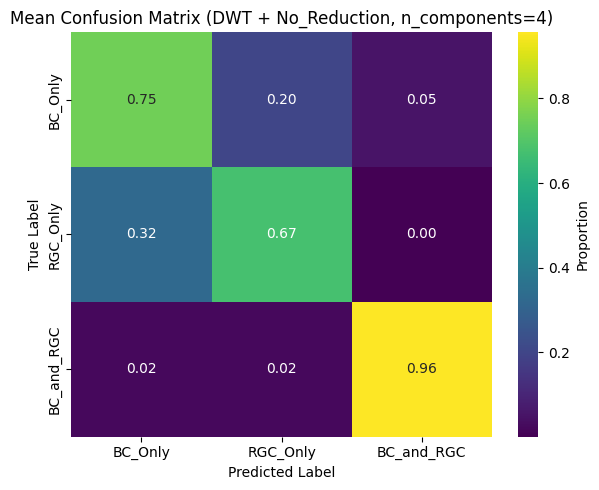


=== DWT + PCA ===
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples B

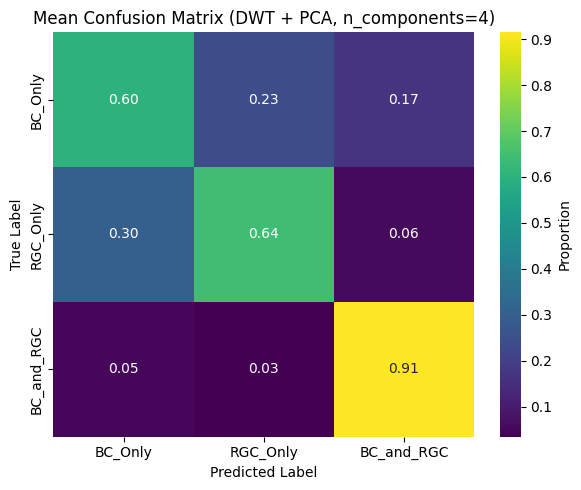


=== DWT + ICA ===
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tole

No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


No of samples BC: 29, RGC: 29, BC_and_RGC: 29


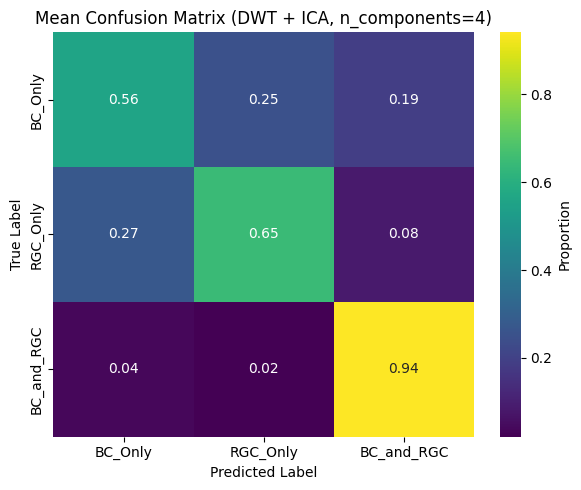


=== Raw + No_Reduction ===
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of 

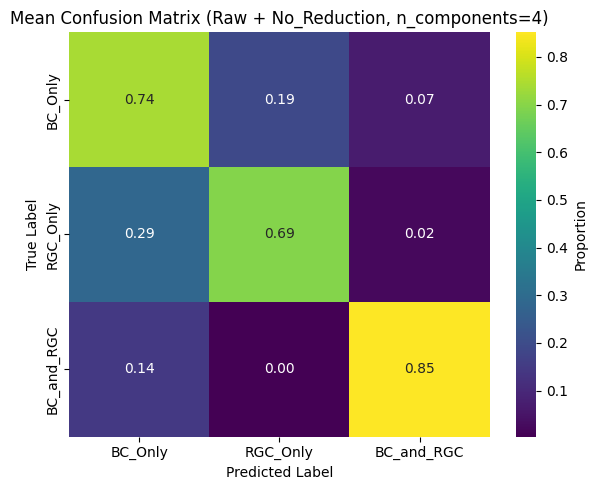


=== Raw + PCA ===
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples B

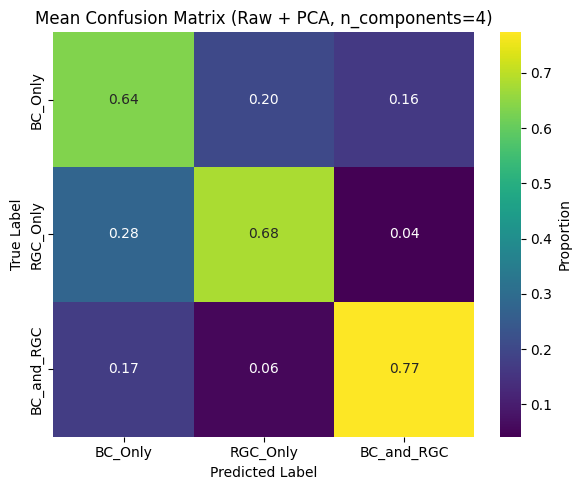


=== Raw + ICA ===
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


No of samples BC: 29, RGC: 29, BC_and_RGC: 29


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tole

No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29
No of samples BC: 29, RGC: 29, BC_and_RGC: 29


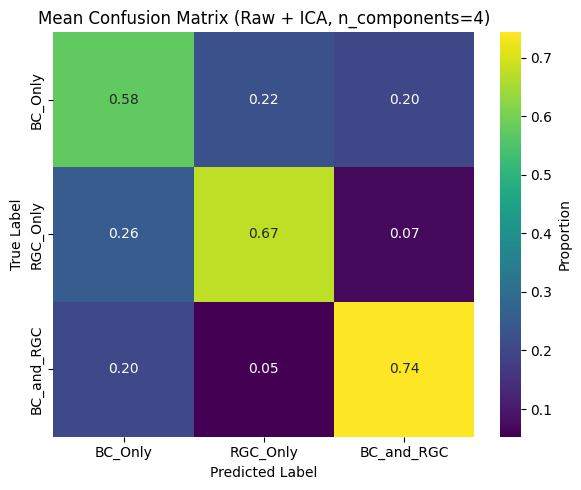

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from helpers import parse_filename

# ============================================================
# MAIN EXPERIMENT PIPELINE
# ============================================================
# all_paths = load_dataset_paths()
# prima_files_BC_only = all_paths["PRIMA"]["BC_Only"]
# prima_files_RGC_only = all_paths["PRIMA"]["RGC_Only"]
# prima_files_BC_and_RGC = all_paths["PRIMA"]["BC_and_RGC"]

feature_types = ["DWT", "Raw"]
reduction_methods = [
    {"name": "No_Reduction", "args": {}},
    {"name": "PCA", "args": {"use_pca": True}},
    {"name": "ICA", "args": {"use_ica": True}},
]

average_results = {}
n_repeats = 30
n_components = 4

def compute_features_subset(sampled_BC, sampled_RGC, sampled_BC_and_RGC, feature_type="DWT"):
    feats, labels = [], []
    for label, files in [
        ("BC_Only", sampled_BC),
        ("RGC_Only", sampled_RGC),
        ("BC_and_RGC", sampled_BC_and_RGC),
    ]:
        for f in files:
            _, sig = load_vep_csv(f, normalize=True, t_min=10, t_max=200)

            if feature_type == "Raw":
                feat = sig
            elif feature_type == "DWT":
                feat = FeatureExtractor.extract_dwt_features(sig)
            elif feature_type == "FFT":
                feat = FeatureExtractor.extract_fft_features(sig)
            elif feature_type == "Time":
                feat = FeatureExtractor.extract_time_features(sig)
            elif feature_type == "Combined":
                feat = FeatureExtractor.extract_combined_features(sig)
            else:
                raise ValueError("Unknown feature type.")

            feats.append(feat)
            labels.append(label)
    return np.array(feats, dtype=object), np.array(labels)

for feature_type in feature_types:
    for method in reduction_methods:
        if method['name'] == 'No_Reduction':
            dim_reducer = None
        else:
            dim_reducer = DimensionalityReducer(n_pca=n_components, n_ica=n_components, random_state=42)
        print(f"\n=== {feature_type} + {method['name']} ===")
        results = []
        all_conf_matrices = []
        for exp in range(n_repeats):
            np.random.seed(42 + exp)
            n_samples = min(len(prima_files_BC_only), len(prima_files_RGC_only), len(prima_files_BC_and_RGC))
            sampled_BC = np.random.choice(prima_files_BC_only, n_samples, replace=False)
            sampled_RGC = np.random.choice(prima_files_RGC_only, n_samples, replace=False)
            sampled_BC_and_RGC = np.random.choice(prima_files_BC_and_RGC, n_samples, replace=False)
            print(f"No of samples BC: {len(sampled_BC)}, RGC: {len(sampled_RGC)}, BC_and_RGC: {len(sampled_BC_and_RGC)}")

            X, labels = compute_features_subset(sampled_BC, sampled_RGC, sampled_BC_and_RGC, feature_type)

            clf = SVMClassifier(X, labels, dim_reducer=dim_reducer)
            y_true, y_pred = clf.fit(**method["args"])
            metrics = clf.evaluate(y_true, y_pred)

            results.append({
                "Accuracy": metrics["accuracy"],
                "BalancedAcc": metrics["balanced_accuracy"],
                "F1": metrics["f1_score"],
                "Acc BC_Only": metrics["report"]["BC_Only"]["recall"],
                "Acc RGC_and_BC": metrics["report"]["BC_and_RGC"]["recall"],
                "Acc RGC_Only": metrics["report"]["RGC_Only"]["recall"],
            })


            all_conf_matrices.append(
                confusion_matrix(
                    y_true, y_pred, labels=["BC_Only", "RGC_Only", "BC_and_RGC"]
                )
            )

            average_results[(feature_type, method["name"], n_components)] = {
                "Accuracy_mean": np.mean([r["Accuracy"] for r in results]),
                "Accuracy_std": np.std([r["Accuracy"] for r in results]),
                "BalancedAcc_mean": np.mean([r["BalancedAcc"] for r in results]),
                "BalancedAcc_std": np.std([r["BalancedAcc"] for r in results]),
                "F1_mean": np.mean([r["F1"] for r in results]),
                "F1_std": np.std([r["F1"] for r in results]),

                # per-class accuracies (recall)
                "Acc_BC_Only_mean": np.mean([r["Acc BC_Only"] for r in results]),
                "Acc_BC_Only_std": np.std([r["Acc BC_Only"] for r in results]),
                "Acc_RGC_Only_mean": np.mean([r["Acc RGC_Only"] for r in results]),
                "Acc_RGC_Only_std": np.std([r["Acc RGC_Only"] for r in results]),
                "Acc_BC_and_RGC_mean": np.mean([r["Acc RGC_and_BC"] for r in results]),
                "Acc_BC_and_RGC_std": np.std([r["Acc RGC_and_BC"] for r in results]),
            }
        mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
        mean_conf_matrix = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True)

        labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]

        plt.figure(figsize=(6,5))
        sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="viridis", 
                    xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Proportion'})

        plt.title(f"Mean Confusion Matrix ({feature_type} + {method['name'] + f', n_components={n_components}'})")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

In [7]:
summarize_results_and_save(average_results, model_name="SVM")


Top 10 setups by F1 Score:
Model Feature_Type Dim_Reduction  n_components    Condition F1 (mean ± std) BC_Only (mean ± std) RGC_Only (mean ± std) BC_and_RGC (mean ± std)
  SVM          DWT           NaN             4 No_Reduction   0,793 ± 0,035        0,749 ± 0,087         0,675 ± 0,061           0,956 ± 0,015
  SVM          Raw           NaN             4 No_Reduction   0,765 ± 0,039         0,74 ± 0,074         0,694 ± 0,071           0,852 ± 0,018
  SVM          DWT           PCA             4          NaN   0,714 ± 0,056        0,599 ± 0,114         0,645 ± 0,081           0,915 ± 0,037
  SVM          DWT           ICA             4          NaN   0,707 ± 0,053         0,56 ± 0,095         0,646 ± 0,088            0,941 ± 0,04
  SVM          Raw           PCA             4          NaN    0,698 ± 0,04         0,636 ± 0,09         0,682 ± 0,066           0,774 ± 0,057
  SVM          Raw           ICA             4          NaN   0,665 ± 0,037        0,576 ± 0,098         0,675 ± 0

## SVM boundaries visualization


=== Visualizing Raw Features ===


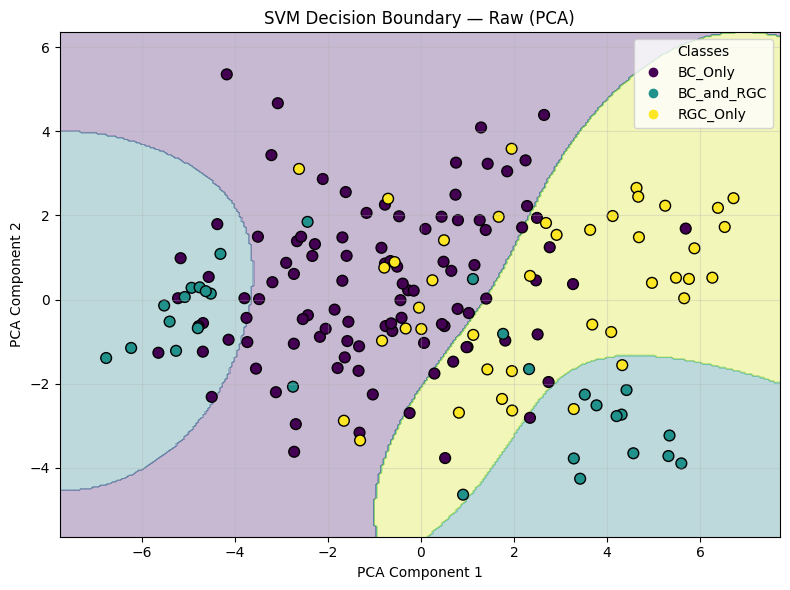

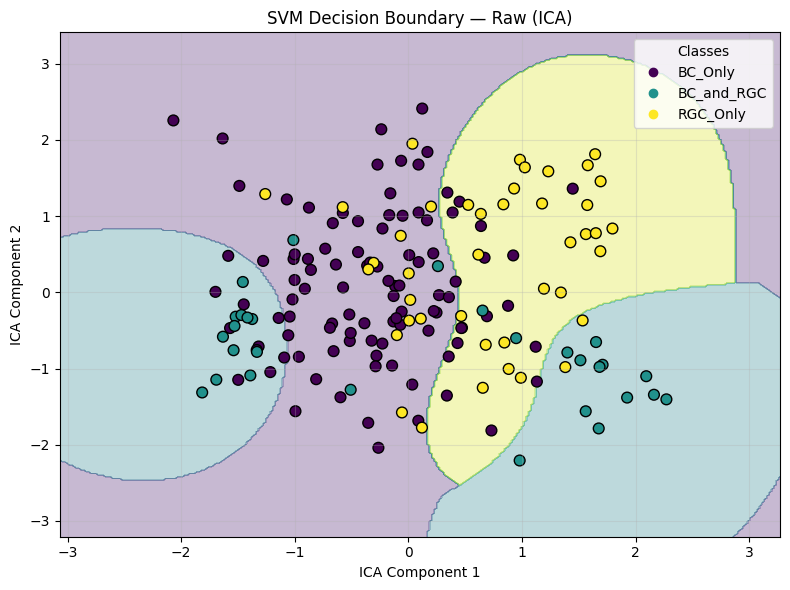


=== Visualizing DWT Features ===


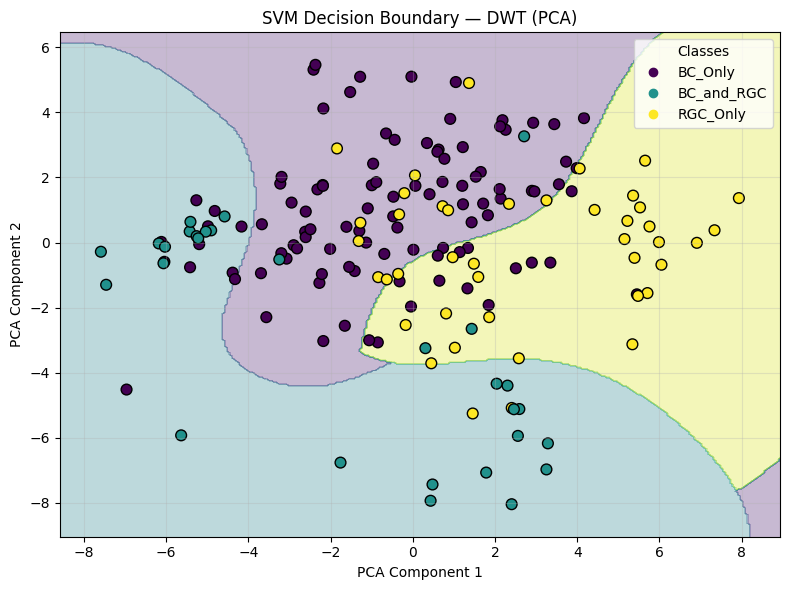

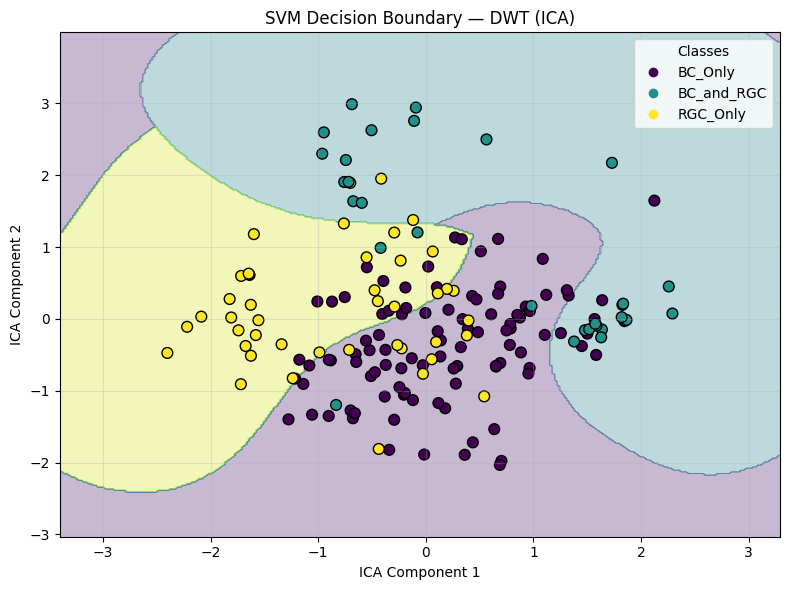

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import LabelEncoder
# ============================================================
# Decision Boundary Visualizer
# ============================================================
def visualize_boundaries(X, y, method="PCA", clf=None, title=None):
    """
    Visualize 2D decision boundaries after dimensionality reduction (PCA, ICA, UMAP).
    Works with string class labels.
    """
    # --- Ensure array format ---
    X = np.vstack(X)
    y = np.array(y)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    class_names = label_encoder.classes_

    # --- 2D Projection ---
    method = method.upper()
    if method == "PCA":
        X_2d = PCA(n_components=2, random_state=42).fit_transform(X)
        proj_name = "PCA"
    elif method == "ICA":
        X_2d = FastICA(n_components=2, random_state=42).fit_transform(X)
        proj_name = "ICA"
    else:
        raise ValueError(f"Unknown projection method: {method}")

    # --- Classifier ---
    if clf is None:
        clf = SVC(kernel="rbf", C=1, gamma="scale", class_weight="balanced", random_state=42)
    clf.fit(X_2d, y_encoded)

    # --- Mesh grid for decision surface ---
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # --- Plot ---
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="viridis")
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_encoded, cmap="viridis", edgecolor="k", s=60)
    legend_handles, _ = scatter.legend_elements()
    plt.legend(legend_handles, class_names, title="Classes")
    plt.title(title or f"Decision Boundary ({proj_name})")
    plt.xlabel(f"{proj_name} Component 1")
    plt.ylabel(f"{proj_name} Component 2")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================
# Run visualization for ALL feature types and ALL projections
# ============================================================

feature_types = ["Raw", "DWT"]
projection_methods = ["PCA", "ICA"]

for feature_type in feature_types:
    print(f"\n=== Visualizing {feature_type} Features ===")
    X_example, y_example = compute_features_subset(
        prima_files_BC_only,
        prima_files_RGC_only,
        prima_files_BC_and_RGC,
        feature_type=feature_type
    )

    for method in projection_methods:
        title = f"SVM Decision Boundary — {feature_type} ({method})"
        visualize_boundaries(X_example, y_example, method=method, title=title)


## PCA demonstration

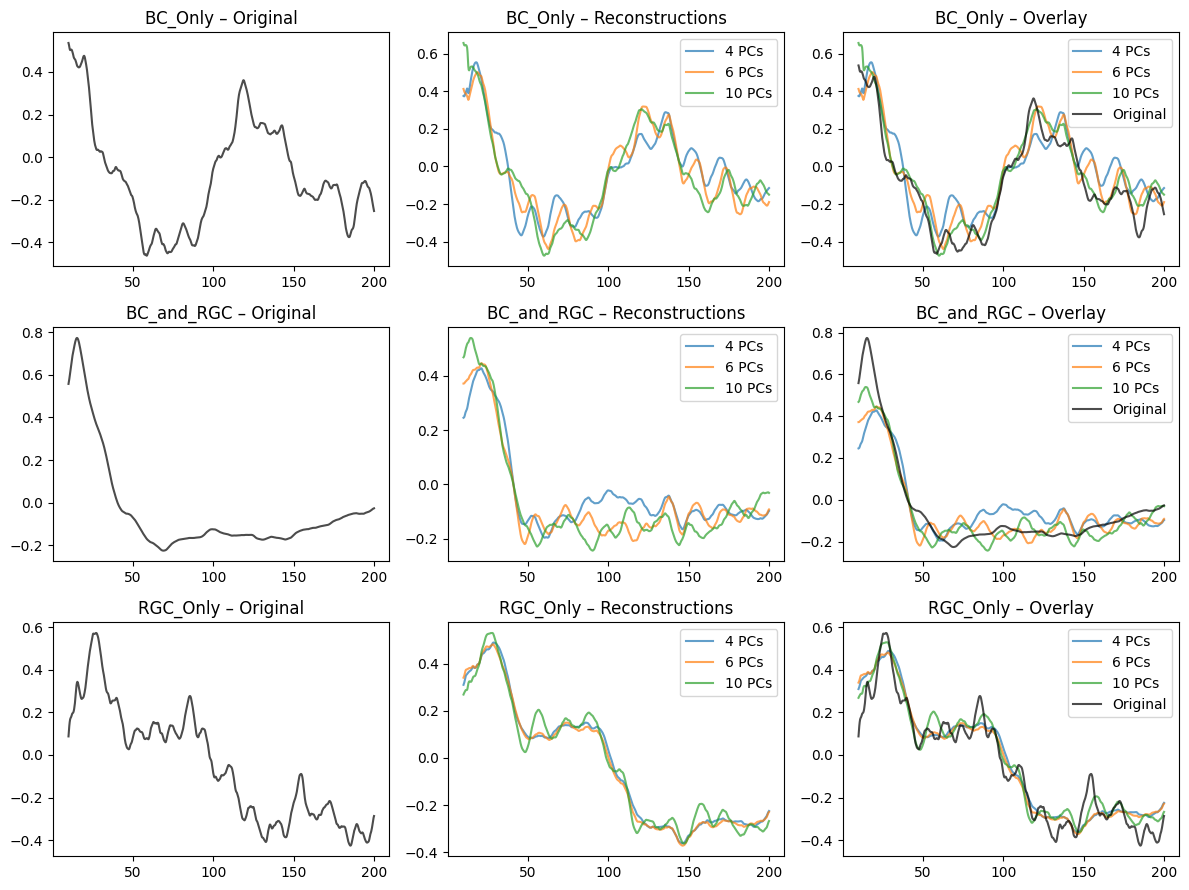

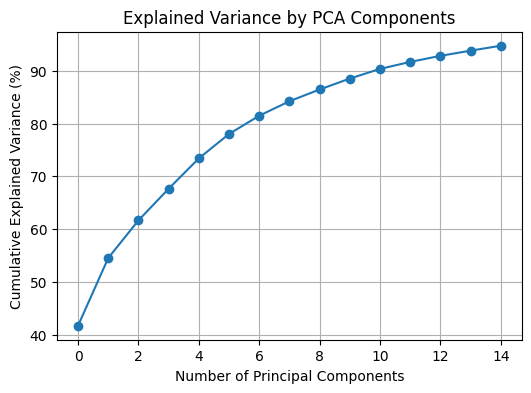

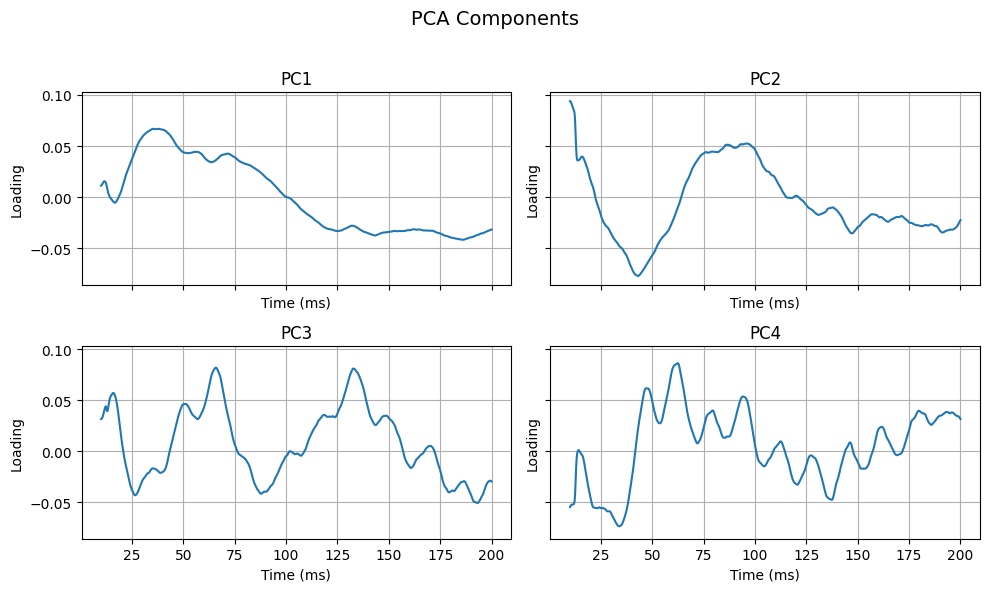

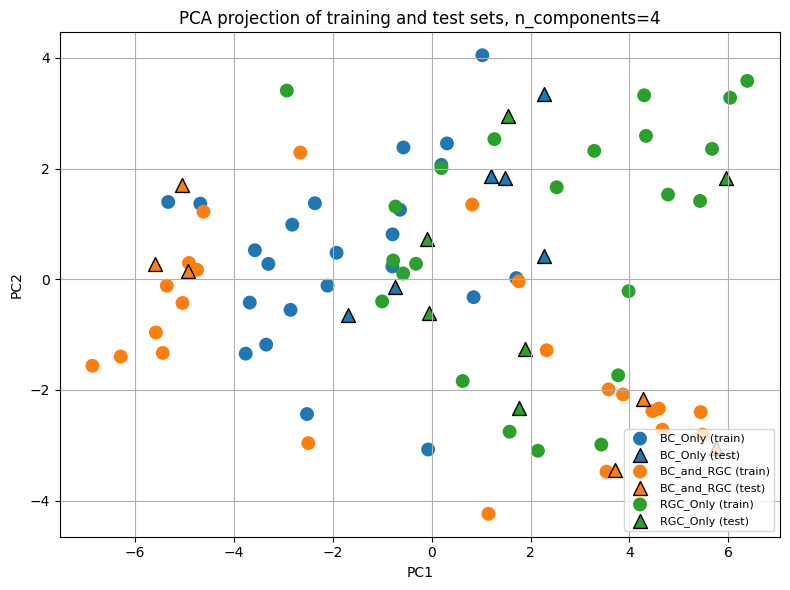

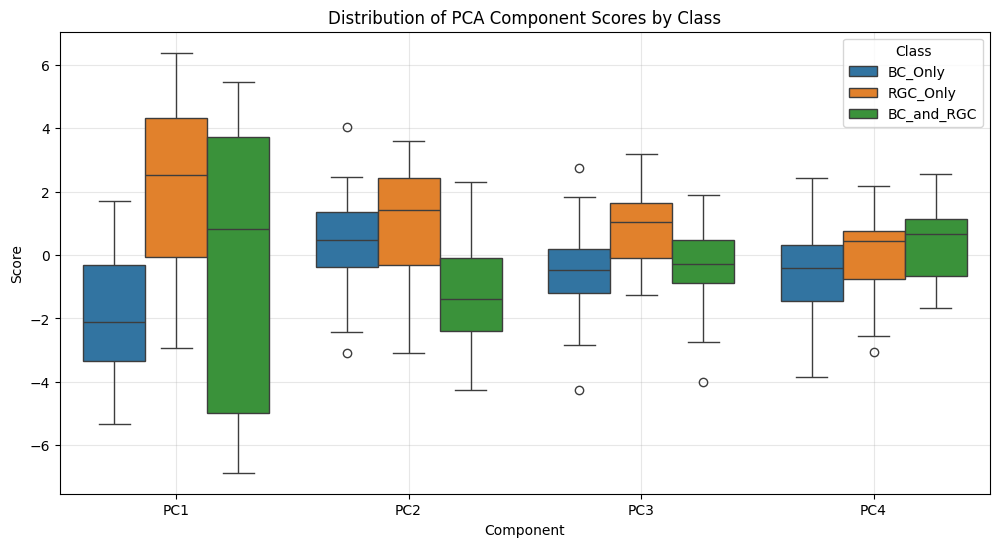

In [9]:
from sklearn.model_selection import train_test_split

average_results = {}
n_repeats = 20
np.random.seed(42)

n_samples = min(len(prima_files_BC_only), len(prima_files_RGC_only), len(prima_files_BC_and_RGC))
sampled_BC = np.random.choice(prima_files_BC_only, n_samples, replace=False)
sampled_RGC = np.random.choice(prima_files_RGC_only, n_samples, replace=False)
sampled_BC_and_RGC = np.random.choice(prima_files_BC_and_RGC, n_samples, replace=False)

X, labels = [], []
for label, files in [
    ("BC_Only", sampled_BC),
    ("RGC_Only", sampled_RGC),
    ("BC_and_RGC", sampled_BC_and_RGC),
]:
    for f in files:
        times, sig = load_vep_csv(f, normalize=True, t_min=10, t_max=200)

        X.append(sig)
        labels.append(label)

# make train test split with balanced classes
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, stratify=labels, random_state=42
)


# fit PCA
n_components_list = [4, 6, 10]

# Prepare figure
unique_classes = sorted(set(y_train))
fig, axes = plt.subplots(len(unique_classes), 3, figsize=(12, 3 * len(unique_classes)))

# For each class, reconstruct with different PCA component counts
for i, cls in enumerate(unique_classes):
    idx = next(j for j, label in enumerate(y_train) if label == cls)
    original_signal = X_train[idx]

    # plot original once
    axes[i, 0].plot(times, original_signal, color ="black", label="Original", alpha=0.7)
    axes[i, 0].set_title(f"{cls} – Original")

    # store reconstructions for each PCA config
    reconstructed_signals = {}
    for n_comp in n_components_list:
        pca = PCA(n_components=n_comp, random_state=42)
        X_pca = pca.fit_transform(X_train)
        reconstructed_signal = pca.inverse_transform(X_pca[idx])
        reconstructed_signals[n_comp] = reconstructed_signal

        # plot each reconstruction (different colors)
        axes[i, 1].plot(times, reconstructed_signal, label=f"{n_comp} PCs", alpha=0.7)
        axes[i, 2].plot(times, reconstructed_signal, label=f"{n_comp} PCs", alpha=0.7)

    # Overlay original in overlay subplot
    axes[i, 2].plot(times, original_signal, color="black", label="Original", alpha=0.7)

    # Titles and legends
    axes[i, 1].set_title(f"{cls} – Reconstructions")
    axes[i, 2].set_title(f"{cls} – Overlay")
    axes[i, 1].legend()
    axes[i, 2].legend()

plt.tight_layout()
plt.show()


# -------------------------------------------
# Plot expalined variance
# -------------------------------------------
pca = PCA(n_components=15, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, 'o-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()


# -------------------------------------------
# Plot first PCs
# -------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat[:4]):
    ax.plot(times, pca.components_[i])
    ax.set_title(f"PC{i+1}")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Loading")
    ax.grid(True)

plt.suptitle("PCA Components", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# -------------------------------------------
# Plot train vs test set
# -------------------------------------------
n_components = 4
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Plot first two PCA components for train vs test
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Create consistent color mapping by class
unique_classes = sorted(set(y_train))
colors = dict(zip(unique_classes, plt.cm.tab10.colors[:len(unique_classes)]))

# Scatter train and test points
for cls in unique_classes:
    mask_train = np.array(y_train) == cls
    mask_test = np.array(y_test) == cls

    ax.scatter(
        X_train_pca[mask_train, 0],
        X_train_pca[mask_train, 1],
        label=f"{cls} (train)",
        color=colors[cls],
        edgecolor="none",
        marker="o",
        s=100
    )
    ax.scatter(
        X_test_pca[mask_test, 0],
        X_test_pca[mask_test, 1],
        label=f"{cls} (test)",
        color=colors[cls],
        edgecolor="black",
        marker="^",
        s=100
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title(f"PCA projection of training and test sets, n_components={n_components}")
ax.legend(fontsize=8, loc="lower right")
ax.grid(True)
plt.tight_layout()
plt.show()


# -------------------------------------------
# Plot component distributions
# -------------------------------------------
# Create dataframe with PCs and labels
df_pca = pd.DataFrame(X_train_pca, columns=[f"PC{i+1}" for i in range(X_train_pca.shape[1])])
df_pca["Class"] = y_train

# Plot first few PCs
plt.figure(figsize=(12, 6))
df_melt = df_pca.melt(id_vars="Class", var_name="Component", value_name="Score")
sns.boxplot(data=df_melt, x="Component", y="Score", hue="Class")
plt.title("Distribution of PCA Component Scores by Class")
plt.grid(True, alpha=0.3)
plt.show()



/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


<Figure size 600x400 with 0 Axes>

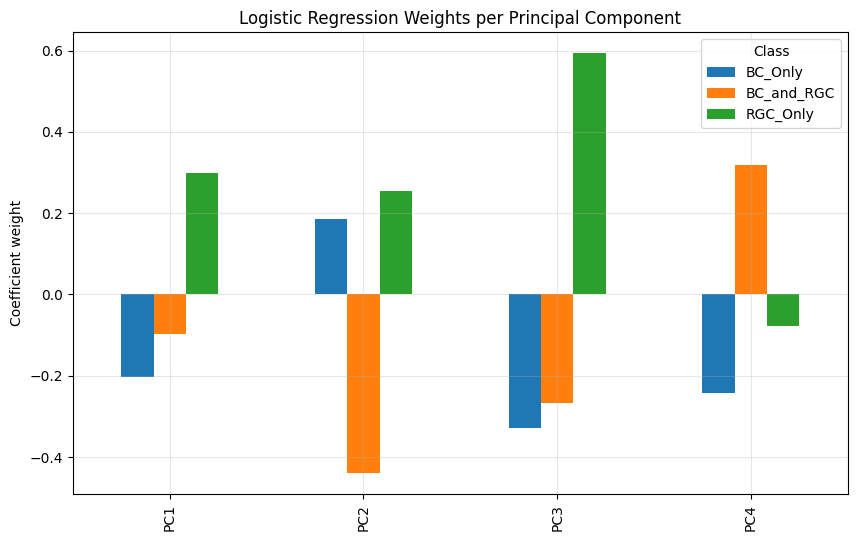

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Encode string labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_train)

clf = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs")
clf.fit(X_train_pca, y_encoded)

# Inspect coefficients (importance per PC per class)
plt.figure(figsize=(6, 4))
coef_df = pd.DataFrame(clf.coef_, columns=[f"PC{i+1}" for i in range(X_train_pca.shape[1])])
coef_df["Class"] = le.classes_
coef_df.set_index("Class", inplace=True)
coef_df.T.plot(kind="bar", figsize=(10,6))
plt.ylabel("Coefficient weight")
plt.title("Logistic Regression Weights per Principal Component")
plt.grid(True, alpha=0.3)
plt.show()
